In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

tensorflow version:  2.4.1
keras version:  2.4.3


In [5]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional, SimpleRNN
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
#Load the audio files

dataset = []
for folder in ["/content/drive/MyDrive/Dataset/set_a/**","/content/drive/MyDrive/Dataset/set_b/**"]:
  for filename in glob.iglob(folder):
    if os.path.exists(filename):
      label = os.path.basename(filename).split("_")[0]
      duration = librosa.get_duration(filename=filename)
      # skip audio smaller than 2 secs
      if duration>=2:
        slice_size = 2
        iterations = int((duration-slice_size)/(slice_size-1))
        iterations += 1
        initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
        if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
          for i in range(iterations):
            offset = initial_offset + i*(slice_size-1)
            if (label == "normal"):
              dataset.append({"filename": filename,"label": "normal","offset": offset})
            elif (label == "murmur"):
                dataset.append({"filename": filename,"label": "murmur","offset": offset})
            elif (label == "extrastole"):
                dataset.append({"filename": filename,"label": "extrastole","offset": offset})
            elif (label == "extrahls"):
                dataset.append({"filename": filename,"label": "extrastole","offset": offset})
            else:
                dataset.append({"filename": filename,"label": "artifact","offset": offset})
                           
                        


In [7]:
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4487 entries, 157 to 860
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4487 non-null   object 
 1   label     4487 non-null   object 
 2   offset    4487 non-null   float64
dtypes: float64(1), object(2)
memory usage: 140.2+ KB


In [ ]:
dataset.head()

,filename,label,offset
157,/content/drive/MyDrive/Dataset/set_a/artifact_...,artifact,5.000000
2992,/content/drive/MyDrive/Dataset/set_b/normal__1...,normal,0.316375
1018,/content/drive/MyDrive/Dataset/set_a/murmur__2...,murmur,1.467778
3466,/content/drive/MyDrive/Dataset/set_b/normal__1...,normal,1.106750
731,/content/drive/MyDrive/Dataset/set_a/extrahls_...,extrastole,7.000000


In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Training Dataset size: %i" % len(train))
print("Testing Dataset Size: %i" % len(test))

Training Dataset size: 3589
Testing Dataset Size: 898


In [ ]:
print('Minimum samples in a class in train data = ', min(train.label.value_counts()))
print('Maximum samples in a class in train data = ', max(train.label.value_counts()))
print('Minimum samples in a class in test data = ', min(test.label.value_counts()))
print('Minimum samples in a class in test data  = ', max(test.label.value_counts()))

Minimum samples in a class in train data =  361
Maximum samples in a class in train data =  1835
Minimum samples in a class in test data =  71
Minimum samples in a class in test data  =  463


In [ ]:
#Check Sampling Rate of files
dataset_sampling = []
for folder in ["/content/drive/MyDrive/Dataset/set_a/**","/content/drive/MyDrive/Dataset/set_b/**"]:
  for filename in glob.iglob(folder):
    if os.path.exists(filename):
      label = os.path.basename(filename).split("_")[0]
      y, sr = librosa.load(filename)
      Signal_Length=len(y)
      Duration=len(y)/sr
      dataset_sampling.append({"filename": filename,"sampling rate": sr,"Signal_Length":Signal_Length,"Duration":Duration})

dataset_sampling_Final = pd.DataFrame(dataset_sampling)
dataset_sampling_Final = shuffle(dataset_sampling_Final, random_state=42)
dataset_sampling_Final.info()
dataset_sampling_Final.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 610 to 102
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       832 non-null    object 
 1   sampling rate  832 non-null    int64  
 2   Signal_Length  832 non-null    int64  
 3   Duration       832 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 32.5+ KB


,filename,sampling rate,Signal_Length,Duration
610,/content/drive/MyDrive/Dataset/set_b/normal__2...,22050,51366,2.329524
819,/content/drive/MyDrive/Dataset/set_b/normal_no...,22050,89551,4.061270
290,/content/drive/MyDrive/Dataset/set_b/normal__2...,22050,65147,2.954512
559,/content/drive/MyDrive/Dataset/set_b/normal__1...,22050,137350,6.229025
168,/content/drive/MyDrive/Dataset/set_a/normal__2...,22050,198450,9.000000
687,/content/drive/MyDrive/Dataset/set_b/normal__2...,22050,27254,1.236009
818,/content/drive/MyDrive/Dataset/set_b/normal_no...,22050,73868,3.350023
86,/content/drive/MyDrive/Dataset/set_a/extrahls_...,22050,173759,7.880227
260,/content/drive/MyDrive/Dataset/set_b/normal__1...,22050,91232,4.137506
547,/content/drive/MyDrive/Dataset/set_b/normal__1...,22050,84292,3.822766


## **Feature Extraction- MFCC and Mel Spectogram**

In [ ]:
#Feature Extraction
def extract_features(audio_path,offset):
    y, sr = librosa.load(audio_path, offset=offset, duration=2)
    #normalizing the data
    y = librosa.util.normalize(y)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

    return mfccs


In [ ]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    


100%|██████████| 898/898 [01:28<00:00, 10.19it/s]


In [ ]:
#Convert into number array
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

X train: (3589, 40, 87)
X test: (898, 40, 87)


/content/drive/MyDrive/Dataset/set_a/artifact__201106010559.wav
/content/drive/MyDrive/Dataset/set_b/normal_noisynormal_123_1306331925797_B.wav
/content/drive/MyDrive/Dataset/set_b/murmur__122_1306325762831_C.wav
/content/drive/MyDrive/Dataset/set_a/extrahls__201103200218.wav


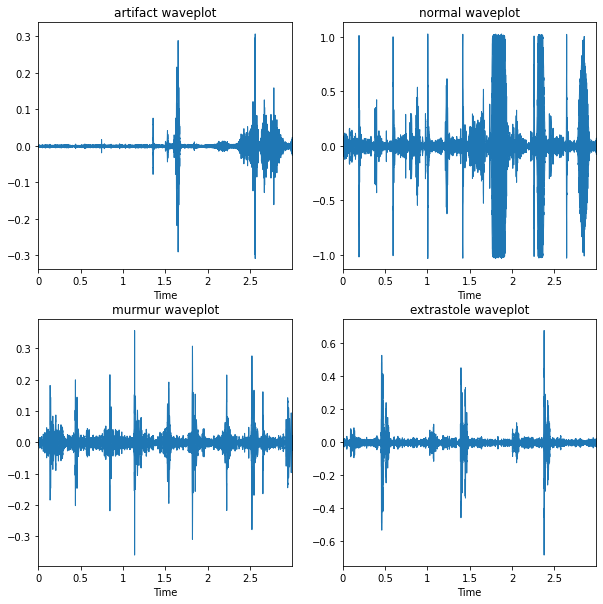

In [ ]:
#Wave Plot
plt.figure(figsize=(10,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    idx+=1
    plt.subplot(2, 2, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveplot(y, sr=sr)


/content/drive/MyDrive/Dataset/set_a/artifact__201106010559.wav
/content/drive/MyDrive/Dataset/set_b/normal_noisynormal_123_1306331925797_B.wav
/content/drive/MyDrive/Dataset/set_b/murmur__122_1306325762831_C.wav
/content/drive/MyDrive/Dataset/set_a/extrahls__201103200218.wav


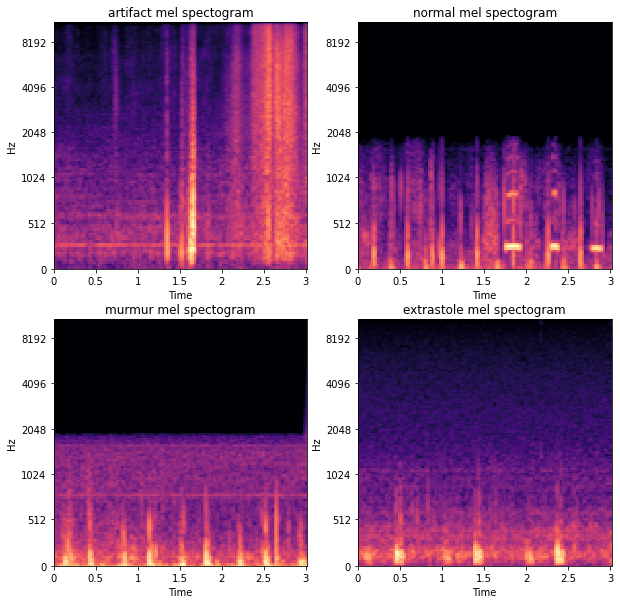

In [ ]:
plt.figure(figsize=(10,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 2, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label)



In [ ]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

print("Encoded Labels=",y_train)



Encoded Labels= [3 3 0 ... 2 2 2]


In [ ]:
#See which Label is associated with what label.
encoder_copy = LabelEncoder()
mapping_df = train[['label']].copy() #Create an extra dataframe which will be used to address only the encoded values
mapping_df['Encoded Labels'] = encoder_copy.fit_transform(train['label'].values) #Using values is faster than using list
mapping_df.head(200)

,label,Encoded Labels
1836,normal,3
3891,normal,3
438,artifact,0
2074,normal,3
2989,normal,3
...,...,...
1297,normal,3
2079,murmur,2
3370,normal,3
1433,normal,3


In [ ]:
#Computer C;lass weights

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weight_dict = dict(enumerate(class_weights))

# **Reshape the data into 2D-numpy array for machine learning models**

In [ ]:
nsamples,nx, ny = x_train.shape
x_train_reshape = x_train.reshape((nsamples,nx*ny))
nsamples,nx, ny = x_test.shape
x_test_reshape = x_test.reshape((nsamples,nx*ny))


In [ ]:
#Code for imbalance datasetfrom imblearn.over_sampling import SMOTE
##sm = SMOTE()
##x_train_reshape, y_train = sm.fit_sample(x_train_reshape, y_train)
#x_test_reshape, y_test = sm.fit_sample(x_test_reshape, y_test)


# **DONOT USE STANDARIZATION CODE BECAUSE WE ALREADY NORMALIZED DATA WHILE LOADING.Scale the data for machine learning models**

In [ ]:
#Scaling for ML models
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#sc = StandardScaler()

#x_train_scaled =  sc.fit_transform(x_train_reshape)
#x_test_scaled = sc.transform(x_test_reshape)


# **Random Forest**

              precision    recall  f1-score   support

           0       0.95      0.73      0.82       124
           1       1.00      0.04      0.08        71
           2       0.88      0.50      0.63       240
           3       0.67      0.97      0.80       463

    accuracy                           0.73       898
   macro avg       0.87      0.56      0.58       898
weighted avg       0.79      0.73      0.70       898

0.734966592427617


[Text(0.5, 1.0, 'Random Forest Correlation Matrix')]

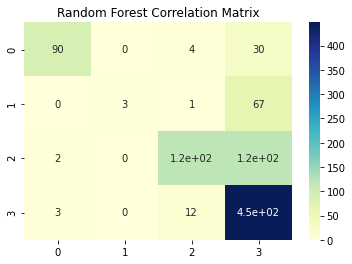

In [ ]:
#Training the Algorithm

Rf_Model=RandomForestClassifier(n_estimators=500,random_state=42)
Rf_Model.fit(x_train_reshape,y_train)


#Predict
y_predrf=Rf_Model.predict(x_test_reshape)
accuracy_score(y_test,y_predrf)

#create confusion matrix

print(classification_report(y_test,y_predrf))
print(accuracy_score(y_test, y_predrf))


sns.heatmap(confusion_matrix(y_test,y_predrf),annot=True,cmap="YlGnBu").set(title="Random Forest Correlation Matrix")


## **Gradient Boost-XG Boost**

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       124
           1       0.31      0.11      0.16        71
           2       0.74      0.52      0.61       240
           3       0.67      0.88      0.76       463

    accuracy                           0.70       898
   macro avg       0.66      0.55      0.58       898
weighted avg       0.69      0.70      0.68       898

0.6971046770601337


[Text(0.5, 1.0, 'Gradient Boost Correlation Matrix')]

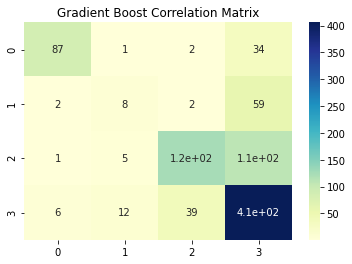

In [ ]:

model_xgboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_features=2, max_depth=2, random_state=42)
model_xgboost.fit(x_train_reshape, y_train)


#Predict
y_predrf=model_xgboost.predict(x_test_reshape)
accuracy_score(y_test,y_predrf)

#create confusion matrix

print(classification_report(y_test,y_predrf))
print(accuracy_score(y_test, y_predrf))

sns.heatmap(confusion_matrix(y_test,y_predrf),annot=True,cmap="YlGnBu").set(title="Gradient Boost Correlation Matrix")


# **SVM**

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       124
           1       0.12      0.20      0.15        71
           2       0.52      0.52      0.52       240
           3       0.65      0.58      0.61       463

    accuracy                           0.55       898
   macro avg       0.49      0.50      0.49       898
weighted avg       0.58      0.55      0.56       898

0.5512249443207127


[Text(0.5, 1.0, 'SVM Correlation Matrix')]

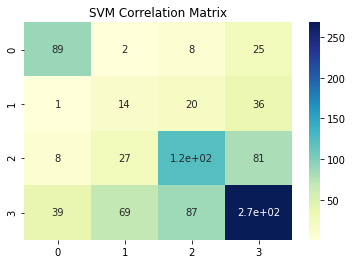

In [ ]:
#Create a svm Classifier
svm_Model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_Model.fit(x_train_reshape, y_train)

#Predict
y_predsvm=svm_Model.predict(x_test_reshape)
accuracy_score(y_test,y_predsvm)

#create confusion matrix

print(classification_report(y_test,y_predsvm))
print(accuracy_score(y_test, y_predsvm))

sns.heatmap(confusion_matrix(y_test,y_predsvm),annot=True,cmap="YlGnBu").set(title="SVM Correlation Matrix")



# **K Nearest Neighbor (KNN)**

              precision    recall  f1-score   support

           0       0.88      0.63      0.73       124
           1       0.27      0.24      0.25        71
           2       0.85      0.60      0.70       240
           3       0.69      0.86      0.77       463

    accuracy                           0.71       898
   macro avg       0.67      0.58      0.61       898
weighted avg       0.73      0.71      0.70       898

0.7104677060133631


[Text(0.5, 1.0, 'KNN Correlation Matrix')]

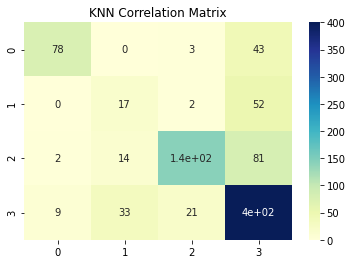

In [ ]:
#Create a KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

#Train the model using the training sets
knn.fit(x_train_reshape, y_train)


#Predict
y_predknn=knn.predict(x_test_reshape)
accuracy_score(y_test,y_predknn)

#create confusion matrix

print(classification_report(y_test,y_predknn))
print(accuracy_score(y_test, y_predknn))

sns.heatmap(confusion_matrix(y_test,y_predknn),annot=True,cmap="YlGnBu").set(title="KNN Correlation Matrix")

# **Naive Bayes**

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       124
           1       0.20      0.18      0.19        71
           2       0.50      0.50      0.50       240
           3       0.67      0.67      0.67       463

    accuracy                           0.59       898
   macro avg       0.52      0.52      0.52       898
weighted avg       0.59      0.59      0.59       898

0.5935412026726058


[Text(0.5, 1.0, 'Naive Bayes Correlation Matrix')]

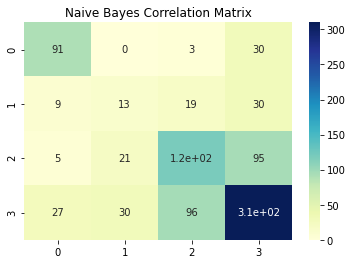

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Classifier
nb = GaussianNB()

#Train the model using the training sets
nb.fit(x_train_reshape, y_train)

#Predict
y_prednb=nb.predict(x_test_reshape)
accuracy_score(y_test,y_prednb)

#create confusion matrix

print(classification_report(y_test,y_prednb))
print(accuracy_score(y_test, y_prednb))

sns.heatmap(confusion_matrix(y_test,y_prednb),annot=True,cmap="YlGnBu").set(title="Naive Bayes Correlation Matrix")

### **DEEP LEARNING MODELS**












# **DNN**- 

In [ ]:
train_DNN, test_DNN = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train_DNN))
print("Test: %i" % len(test_DNN))

Train: 3589
Test: 898


In [ ]:
x_train_DNN = []
x_test_DNN = []

for idx in tqdm(range(len(train_DNN))):
    x_train_DNN.append(extract_features(train_DNN.filename.iloc[idx],train_DNN.offset.iloc[idx]))

for idx in tqdm(range(len(test_DNN))):
    x_test_DNN.append(extract_features(test_DNN.filename.iloc[idx],test_DNN.offset.iloc[idx]))

100%|██████████| 898/898 [01:27<00:00, 10.26it/s]


In [ ]:
x_test_DNN_1 = np.asarray(x_test_DNN)
x_train_DNN_1 = np.asarray(x_train_DNN)

print("X train_DNN_1:", x_train_DNN_1.shape)
print("X test_DNN_1:", x_test_DNN_1.shape)
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train_DNN.label)

y_train_DNN_1 = encoder.transform(train_DNN.label)
y_test_DNN_1 = encoder.transform(test_DNN.label)

print("Y train_DNN_1:", y_train_DNN_1.shape)
print("y test_DNN_1:", y_test_DNN_1.shape)



X train_DNN_1: (3589, 40, 87)
X test_DNN_1: (898, 40, 87)
Y train_DNN_1: (3589,)
y test_DNN_1: (898,)


In [ ]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_DNN_1),np.array(y_train_DNN_1))


In [ ]:
#change the input shapes for DNN models
x_train_DNN_2 = x_train_DNN_1.reshape(x_train_DNN_1.shape[0], x_train_DNN_1.shape[1], x_train_DNN_1.shape[2])
x_test_DNN_2 = x_test_DNN_1.reshape(x_test_DNN_1.shape[0], x_test_DNN_1.shape[1], x_test_DNN_1.shape[2])
y_train_DNN_2 = to_categorical(y_train_DNN_1)
y_test_DNN_2 = to_categorical(y_test_DNN_1)

print("X train DNN:", x_train_DNN_2.shape)
print("Y train DNN:", y_train_DNN_2.shape)
print("X test DNN:", x_test_DNN_2.shape)
print("Y test DNN:", y_test_DNN_2.shape)



X train DNN: (3589, 40, 87)
Y train DNN: (3589, 4)
X test DNN: (898, 40, 87)
Y test DNN: (898, 4)


In [ ]:
x_train_DNN_2  = np.reshape(x_train_DNN_1, (3589, 3480))
x_test_DNN_2  = np.reshape(x_test_DNN_1, (898, 3480))
y_train_DNN_2 = to_categorical(y_train_DNN_1)
y_test_DNN_2 = to_categorical(y_test_DNN_1)

print("X train DNN:", x_train_DNN_2.shape)
print("Y train DNN:", y_train_DNN_2.shape)
print("X test DNN:", x_test_DNN_2.shape)
print("Y test DNN:", y_test_DNN_2.shape)

X train DNN: (3589, 3480)
Y train DNN: (3589, 4)
X test DNN: (898, 3480)
Y test DNN: (898, 4)


In [ ]:
#from imblearn.over_sampling import SMOTE
#sm = SMOTE()
#x_train_DNN_2, y_train_DNN_2 = sm.fit_sample(x_train_DNN_2, y_train_DNN_2)
#x_test_DNN_2, y_test_DNN_2 = sm.fit_sample(x_test_DNN_2, y_test_DNN_2)

In [ ]:
x_train_norm = x_train_DNN_2.astype('float32') / 255
x_test_norm = x_test_DNN_2.astype('float32') / 255
print(set(x_train_norm[0]))

{0.7506372, 0.7563901, 0.74548876, 0.77557504, 0.802403, 0.81681067, 0.81458247, 0.78800845, 0.7776355, 0.77520394, 0.7726862, 0.76597667, 0.7573646, 0.7740932, 0.1846912, -0.056462374, -0.04176904, -0.032684337, -0.062449943, 0.029524911, 0.017849077, 0.0505669, -0.009856712, 0.011590816, 0.023324825, -0.00087278156, -0.05641864, -0.03952874, 0.02284043, 0.013489176, -0.002942633, 0.012057859, 0.043542136, 0.040138103, 0.0841311, -0.034069374, 0.0018846137, 0.017176978, 0.012591416, -0.003545645, 0.8092977, 0.003271222, 0.008122925, 0.016793732, 0.013320048, 0.008565386, -0.010904471, -0.010215442, 0.01161321, 0.011982806, -0.029841535, 0.012624462, 0.0073422985, -0.00202154, -0.015697526, 0.03144743, 0.033968944, -0.0128489835, -0.0005532452, -0.0030128905, 0.0015542558, 0.0033478788, 0.018434905, -0.0038411936, 0.007851602, 0.019052794, -0.027137825, 0.03054314, -0.0077428315, 0.02805536, -0.026134202, -0.030655334, -0.016938874, 0.008598497, 0.015790274, 0.006117087, -0.026893396, 

In [ ]:
#Model 1
model_DNN = Sequential()
model_DNN.add(Dense(12,  input_shape=[3480], activation='relu'))
model_DNN.add(tf.keras.layers.Flatten())
model_DNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                41772     
_________________________________________________________________
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 52        
Total params: 41,824
Trainable params: 41,824
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model 2
model_DNN = Sequential()
model_DNN.add(Dense(32,  input_shape=[3480], activation='relu'))
model_DNN.add(tf.keras.layers.Flatten())
model_DNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                111392    
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 111,524
Trainable params: 111,524
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model 3
model_DNN = Sequential()
model_DNN.add(Dense(64,  input_shape=[3480], activation='relu'))
model_DNN.add(tf.keras.layers.Flatten())
model_DNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_DNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                222784    
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 223,044
Trainable params: 223,044
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model 
model_DNN = Sequential()
model_DNN.add(Dense(128,  input_shape=[3480], activation='relu'))
model_DNN.add(tf.keras.layers.Flatten())
model_DNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_DNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               445568    
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 446,084
Trainable params: 446,084
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model 5
model_DNN = Sequential()
model_DNN.add(Dense(250,  input_shape=[3480], activation='relu'))
model_DNN.add(tf.keras.layers.Flatten())
model_DNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_DNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 250)               870250    
_________________________________________________________________
flatten_4 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1004      
Total params: 871,254
Trainable params: 871,254
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_DNN.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer='adam')


In [ ]:
#Fitting a model
history = model_DNN.fit(x_train_norm, y_train_DNN_2,
              batch_size=128,
              epochs=50,
              validation_data=(x_test_norm, y_test_DNN_2)
              #class_weight=class_weights
              #shuffle=True
              )

Epoch 1/50
29/29 [==============================] - 2s 33ms/step - loss: 1.0962 - accuracy: 0.5210 - val_loss: 0.8759 - val_accuracy: 0.6648
Epoch 2/50
29/29 [==============================] - 0s 17ms/step - loss: 0.8717 - accuracy: 0.6727 - val_loss: 0.8277 - val_accuracy: 0.7016
Epoch 3/50
29/29 [==============================] - 0s 16ms/step - loss: 0.8227 - accuracy: 0.6895 - val_loss: 0.8076 - val_accuracy: 0.7194
Epoch 4/50
29/29 [==============================] - 0s 17ms/step - loss: 0.8036 - accuracy: 0.7032 - val_loss: 0.8230 - val_accuracy: 0.7038
Epoch 5/50
29/29 [==============================] - 0s 17ms/step - loss: 0.7424 - accuracy: 0.7088 - val_loss: 0.7577 - val_accuracy: 0.7127
Epoch 6/50
29/29 [==============================] - 0s 17ms/step - loss: 0.7223 - accuracy: 0.7166 - val_loss: 0.8898 - val_accuracy: 0.5757
Epoch 7/50
29/29 [==============================] - 0s 17ms/step - loss: 0.7519 - accuracy: 0.6781 - val_loss: 0.7588 - val_accuracy: 0.7049
Epoch 8/50
29

Text(0.5, 1.0, 'Accuracy Curves')

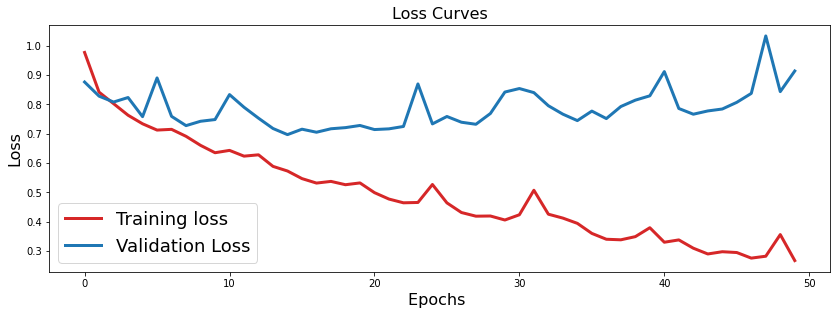

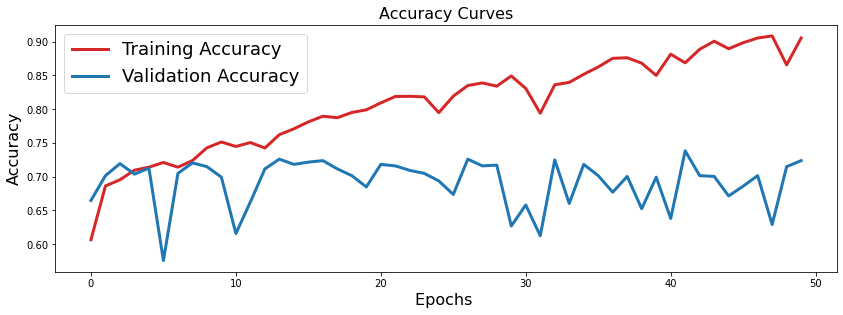

In [ ]:
#evaluating the model
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#Accuracy Score
scores = model_DNN.evaluate(x_test_DNN_2, y_test_DNN_2, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

29/29 [==============================] - 0s 3ms/step - loss: 177.5349 - accuracy: 0.7272
Test loss: 177.53488159179688
Test accuracy: 0.7271714806556702


In [ ]:
#making predictions
predictions = model_DNN.predict(x_test_DNN_2, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_DNN_2[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

29/29 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

    artifact       0.73      0.91      0.81       100
  extrastole       0.11      0.62      0.19        13
      murmur       0.55      0.80      0.65       166
      normal       0.91      0.68      0.78       619

    accuracy                           0.73       898
   macro avg       0.58      0.75      0.61       898
weighted avg       0.81      0.73      0.75       898



# **CNN**

# **Prepare data shapes for CNN**

In [ ]:
train_CNN, test_CNN = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train_CNN))
print("Test: %i" % len(test_CNN))

Train: 3589
Test: 898


In [ ]:
#Feature Extraction
def extract_features(audio_path,offset):
    y, sr = librosa.load(audio_path, offset=offset,duration=2,res_type='kaiser_fast')
    # #normalized raw audio 
    y = librosa.util.normalize(y)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

    return mfccs

In [ ]:
x_train_CNN_1 = []
x_test_CNN_1 = []

for idx in tqdm(range(len(train_CNN))):
    x_train_CNN_1.append(extract_features(train_CNN.filename.iloc[idx],train_CNN.offset.iloc[idx]))

for idx in tqdm(range(len(test_CNN))):
    x_test_CNN_1.append(extract_features(test_CNN.filename.iloc[idx],test_CNN.offset.iloc[idx]))



100%|██████████| 898/898 [00:32<00:00, 27.35it/s]


In [ ]:
x_test_CNN_2 = np.asarray(x_test_CNN_1)
x_train_CNN_2 = np.asarray(x_train_CNN_1)

print("X train CNN:", x_train_CNN_2.shape)
print("X test CNN:", x_test_CNN_2.shape)

# Encode Labels
encoder_CNN = LabelEncoder()
encoder_CNN.fit(train_CNN.label)

y_train_CNN_2 = encoder_CNN.transform(train_CNN.label)
y_test_CNN_2 = encoder_CNN.transform(test_CNN.label)
print("Y train CNN:", y_train_CNN_2.shape)
print("Y test CNN:", y_test_CNN_2.shape)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_CNN_2),np.array(y_train_CNN_2))

X train CNN: (3589, 40, 87)
X test CNN: (898, 40, 87)
Y train CNN: (3589,)
Y test CNN: (898,)


In [ ]:
#change the input shapes for CNN models
x_train_CNN_Final = x_train_CNN_2.reshape(x_train_CNN_2.shape[0], x_train_CNN_2.shape[1], x_train_CNN_2.shape[2],1)
x_test_CNN_Final = x_test_CNN_2.reshape(x_test_CNN_2.shape[0], x_test_CNN_2.shape[1], x_test_CNN_2.shape[2],1)
y_train_CNN_Final = to_categorical(y_train_CNN_2)
y_test_CNN_Final = to_categorical(y_test_CNN_2)

print("X train:", x_train_CNN_Final.shape)
print("Y train:", y_train_CNN_Final.shape)
print("X test:", x_test_CNN_Final.shape)
print("Y test:", y_test_CNN_Final.shape)



X train: (3589, 40, 87, 1)
Y train: (3589, 4)
X test: (898, 40, 87, 1)
Y test: (898, 4)


In [ ]:
#model 1
model_CNN = Sequential()
model_CNN.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train_CNN_Final.shape[1],x_train_CNN_Final.shape[2],x_train_CNN_Final.shape[3]), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.5))
model_CNN.add(GlobalAveragePooling2D())

model_CNN.add(Flatten())
model_CNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 86, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 43, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 43, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 42, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 21, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 21, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 20, 64)        

In [ ]:
#model 2
model_CNN = Sequential()
model_CNN.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train_CNN_Final.shape[1],x_train_CNN_Final.shape[2],x_train_CNN_Final.shape[3]), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.5))

model_CNN.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.5))

model_CNN.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.5))

model_CNN.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.5))
model_CNN.add(GlobalAveragePooling2D())

model_CNN.add(Flatten())
model_CNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_CNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 39, 86, 16)        80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 43, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 43, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 42, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 21, 32)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 21, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 20, 64)        

In [ ]:
#model 3
model_CNN = Sequential()
model_CNN.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train_CNN_Final.shape[1],x_train_CNN_Final.shape[2],x_train_CNN_Final.shape[3]), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(GlobalAveragePooling2D())

model_CNN.add(Flatten())
model_CNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 39, 86, 16)        80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 43, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 19, 43, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 42, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 21, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 21, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 20, 64)        

In [ ]:
#model 4
model_CNN = Sequential()
model_CNN.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train_CNN_Final.shape[1],x_train_CNN_Final.shape[2],x_train_CNN_Final.shape[3]), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))


model_CNN.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))


model_CNN.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))

model_CNN.add(GlobalAveragePooling2D())

model_CNN.add(Flatten())
model_CNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_CNN.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 39, 86, 16)        80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 19, 43, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 42, 32)        2080      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 21, 32)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 9, 21, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 20, 64)         8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 10, 64)        

In [ ]:
#model 5
model_CNN = Sequential()
model_CNN.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train_CNN_Final.shape[1],x_train_CNN_Final.shape[2],x_train_CNN_Final.shape[3]), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))


model_CNN.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))


model_CNN.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))


model_CNN.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=2))
model_CNN.add(GlobalAveragePooling2D())

model_CNN.add(Flatten())
model_CNN.add(Dense(len(encoder.classes_), activation='softmax'))
model_CNN.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 39, 86, 16)        80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 19, 43, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 42, 32)        2080      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 21, 32)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 20, 64)         8256      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 4, 10, 64)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 9, 128)        

In [ ]:

#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_CNN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [ ]:
history = model_CNN.fit(x_train_CNN_Final, y_train_CNN_Final,
              batch_size=128,
              epochs=20,
              validation_data=(x_test_CNN_Final, y_test_CNN_Final)
              #class_weight=class_weight_dict
              #shuffle=True
              )

Epoch 1/20
29/29 [==============================] - 8s 238ms/step - loss: 6.0177 - accuracy: 0.4208 - val_loss: 1.0114 - val_accuracy: 0.4889
Epoch 2/20
29/29 [==============================] - 7s 233ms/step - loss: 1.0143 - accuracy: 0.5808 - val_loss: 0.8270 - val_accuracy: 0.6893
Epoch 3/20
29/29 [==============================] - 7s 232ms/step - loss: 0.8420 - accuracy: 0.6794 - val_loss: 0.8102 - val_accuracy: 0.7038
Epoch 4/20
29/29 [==============================] - 7s 232ms/step - loss: 0.8149 - accuracy: 0.7029 - val_loss: 0.7522 - val_accuracy: 0.7127
Epoch 5/20
29/29 [==============================] - 7s 232ms/step - loss: 0.7718 - accuracy: 0.7078 - val_loss: 0.7477 - val_accuracy: 0.7238
Epoch 6/20
29/29 [==============================] - 7s 233ms/step - loss: 0.7540 - accuracy: 0.7143 - val_loss: 0.7141 - val_accuracy: 0.7272
Epoch 7/20
29/29 [==============================] - 7s 232ms/step - loss: 0.7317 - accuracy: 0.7235 - val_loss: 0.7607 - val_accuracy: 0.6882
Epoch 

Text(0.5, 1.0, 'Accuracy Curves')

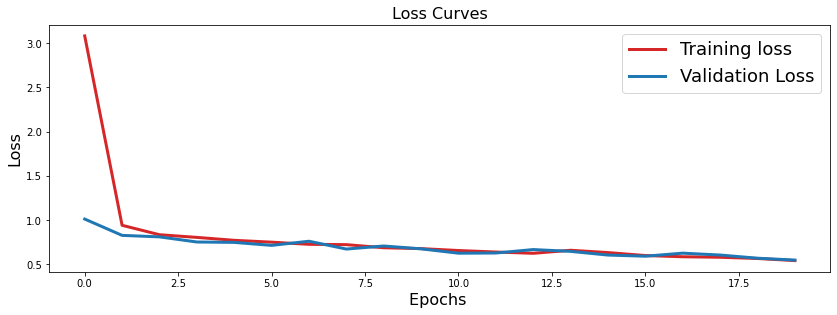

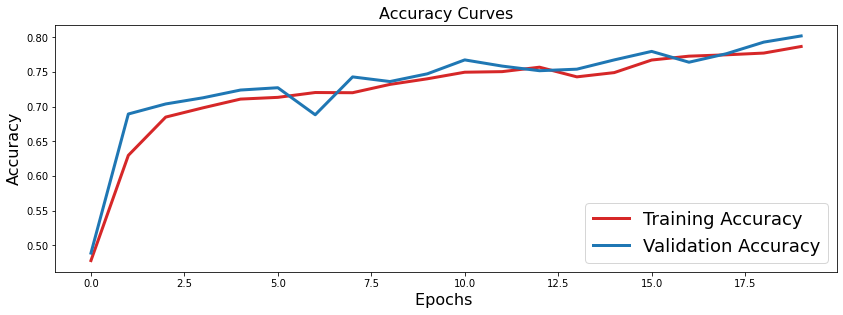

In [ ]:
#evaluating the model
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#Accuracy Score
scores = model_CNN.evaluate(x_test_CNN_Final, y_test_CNN_Final, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

29/29 [==============================] - 1s 20ms/step - loss: 0.5480 - accuracy: 0.8018
Test loss: 0.5479831099510193
Test accuracy: 0.8017817139625549


In [ ]:
#making predictions
predictions = model_CNN.predict(x_test_CNN_Final, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_CNN_Final[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

29/29 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

    artifact       0.73      0.99      0.84        91
  extrastole       0.21      0.75      0.33        20
      murmur       0.77      0.84      0.81       219
      normal       0.93      0.76      0.83       568

    accuracy                           0.80       898
   macro avg       0.66      0.84      0.70       898
weighted avg       0.85      0.80      0.82       898



# **LSTM/RNN**

In [ ]:
x_train_LSTM = []
x_test_LSTM = []

for idx in tqdm(range(len(train))):
    x_train_LSTM.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test_LSTM.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))


100%|██████████| 898/898 [00:33<00:00, 27.12it/s]


In [ ]:
x_test_LSTM = np.asarray(x_test_LSTM)
x_train_LSTM = np.asarray(x_train_LSTM)

print("X train LSTM:", x_train_LSTM.shape)
print("X test LSTM:", x_test_LSTM.shape)

# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train_LSTM = encoder.transform(train.label)
y_test_LSTM = encoder.transform(test.label)
print("y train LSTM :", y_train_LSTM.shape)
print("y test LSTM:", y_test_LSTM.shape)


# Compute class weights
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_LSTM),y_train_LSTM)

X train LSTM: (3589, 40, 87)
X test LSTM: (898, 40, 87)
y train LSTM : (3589,)
y test LSTM: (898,)


In [ ]:
#change the input shapes for LSTM/RNN models
x_train_LSTM = x_train_LSTM.reshape(x_train_LSTM.shape[0], x_train_LSTM.shape[1], x_train_LSTM.shape[2])
x_test_LSTM = x_test_LSTM.reshape(x_test_LSTM.shape[0], x_test_LSTM.shape[1], x_test_LSTM.shape[2])

y_train_LSTM = to_categorical(y_train_LSTM)
y_test_LSTM = to_categorical(y_test_LSTM)

print("X train LSTM:", x_train_LSTM.shape)
print("Y train LSTM:", y_train_LSTM.shape)
print("X test LSTM:", x_test_LSTM.shape)
print("Y test LSTM:", y_test_LSTM.shape)



X train LSTM: (3589, 40, 87)
Y train LSTM: (3589, 4)
X test LSTM: (898, 40, 87)
Y test LSTM: (898, 4)


In [ ]:
print('Build LSTM RNN model ...')

model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(40,87)))
model_lstm.add(Bidirectional(LSTM(32,  return_sequences=False)))
model_lstm.add(Dense(len(encoder.classes_), activation='softmax'))
model_lstm.summary()


Build LSTM RNN model ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 40, 128)           77824     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 119,300
Trainable params: 119,300
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#Fitting a model
history = model_lstm.fit(x_train_LSTM, y_train_LSTM,
              batch_size=128,
              epochs=50,
              validation_data=(x_test_LSTM, y_test_LSTM)
              #class_weight=class_weights,
              #shuffle=True
              )


Epoch 1/50
29/29 [==============================] - 12s 212ms/step - loss: 1.2055 - accuracy: 0.4633 - val_loss: 1.0057 - val_accuracy: 0.6069
Epoch 2/50
29/29 [==============================] - 5s 159ms/step - loss: 0.9643 - accuracy: 0.6156 - val_loss: 0.9170 - val_accuracy: 0.6637
Epoch 3/50
29/29 [==============================] - 5s 160ms/step - loss: 0.8349 - accuracy: 0.6743 - val_loss: 0.8921 - val_accuracy: 0.6604
Epoch 4/50
29/29 [==============================] - 5s 161ms/step - loss: 0.7601 - accuracy: 0.7063 - val_loss: 0.8487 - val_accuracy: 0.6815
Epoch 5/50
29/29 [==============================] - 5s 160ms/step - loss: 0.6100 - accuracy: 0.7775 - val_loss: 0.8774 - val_accuracy: 0.6659
Epoch 6/50
29/29 [==============================] - 5s 160ms/step - loss: 0.5440 - accuracy: 0.7869 - val_loss: 0.9155 - val_accuracy: 0.6136
Epoch 7/50
29/29 [==============================] - 5s 160ms/step - loss: 0.4417 - accuracy: 0.8435 - val_loss: 0.9379 - val_accuracy: 0.6737
Epoch

Text(0.5, 1.0, 'Accuracy Curves')

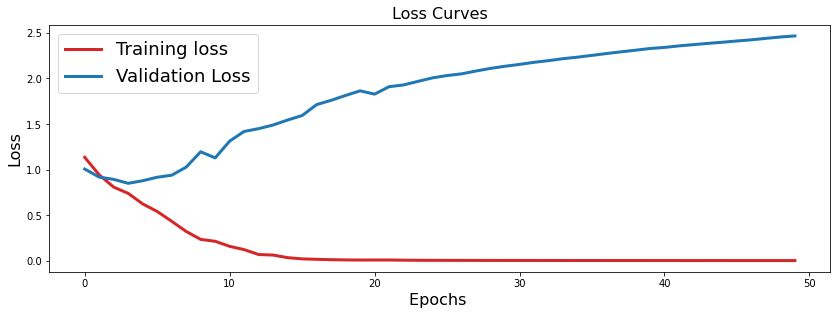

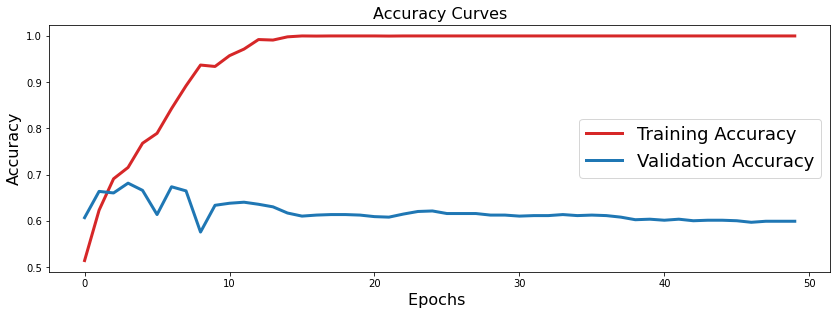

In [ ]:
#evaluating the model
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
#Accuracy Score
scores = model_lstm.evaluate(x_test_LSTM, y_test_LSTM, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

29/29 [==============================] - 1s 17ms/step - loss: 2.4670 - accuracy: 0.5991
Test loss: 2.4670462608337402
Test accuracy: 0.5991091132164001


In [ ]:
#making predictions
predictions = model_lstm.predict(x_test_LSTM, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_LSTM[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

29/29 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

    artifact       0.63      0.78      0.70       100
  extrastole       0.23      0.17      0.20        93
      murmur       0.54      0.59      0.57       220
      normal       0.68      0.65      0.66       485

    accuracy                           0.60       898
   macro avg       0.52      0.55      0.53       898
weighted avg       0.59      0.60      0.59       898



In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu").set(title= "LSTM 2 LAYERS")

ValueError: ignored

# Experiment 2

In [ ]:

model_lstm = Sequential()
model_lstm.add(SimpleRNN(64,return_sequences=True, input_shape=(40,87)))
model_lstm.add(SimpleRNN(32))
model_lstm.add(Dense(len(encoder.classes_), activation='softmax'))
model_lstm.summary()

In [ ]:
#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#Fitting a model
history = model_lstm.fit(x_train_LSTM, y_train_LSTM,
              batch_size=128,
              epochs=50,
              validation_data=(x_test_LSTM, y_test_LSTM)
              #class_weight=class_weights,
              #shuffle=True
              )

In [ ]:
#Accuracy Score
scores = model_lstm.evaluate(x_test_LSTM, y_test_LSTM, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
#making predictions
predictions = model_lstm.predict(x_test_LSTM, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_LSTM[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu").set(title="RNN - 2 LAYERS")

In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(40,87)))
model_lstm.add(LSTM(32,  return_sequences=False))
model_lstm.add(Dense(len(encoder.classes_), activation='softmax'))
model_lstm.summary()

In [ ]:
#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#Fitting a model
history = model_lstm.fit(x_train_LSTM, y_train_LSTM,
              batch_size=128,
              epochs=50,
              validation_data=(x_test_LSTM, y_test_LSTM)
              #class_weight=class_weights,
              #shuffle=True
              )

In [ ]:
#Accuracy Score
scores = model_lstm.evaluate(x_test_LSTM, y_test_LSTM, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
#making predictions
predictions = model_lstm.predict(x_test_LSTM, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_LSTM[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu").set(title="LSTM - 2 LAYERS - 1 UNIDIRECTIONAL LSTM LAYER")

In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(40,87)))
model_lstm.add(Bidirectional(LSTM(128,  return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(128,  return_sequences=False)))
model_lstm.add(Dense(len(encoder.classes_), activation='softmax'))
model_lstm.summary()

In [ ]:
#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#Fitting a model
history = model_lstm.fit(x_train_LSTM, y_train_LSTM,
              batch_size=128,
              epochs=50,
              validation_data=(x_test_LSTM, y_test_LSTM)
              #class_weight=class_weights,
              #shuffle=True
              )

In [ ]:
#Accuracy Score
scores = model_lstm.evaluate(x_test_LSTM, y_test_LSTM, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
#making predictions
predictions = model_lstm.predict(x_test_LSTM, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_LSTM[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu").set(title="LSTM BIDIRECTIONAL - 3 LAYERS - 64, 128 NEURONS")

In [ ]:
model_lstm = Sequential()
model_lstm.add(SimpleRNN(128,return_sequences=True, input_shape=(40,87)))
model_lstm.add(SimpleRNN(64,return_sequences=True))
model_lstm.add(SimpleRNN(64))
model_lstm.add(Dense(len(encoder.classes_), activation='softmax'))
model_lstm.summary()

In [ ]:
#Compiling Model
adam = keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
#Fitting a model
history = model_lstm.fit(x_train_LSTM, y_train_LSTM,
              batch_size=128,
              epochs=50,
              validation_data=(x_test_LSTM, y_test_LSTM)
              #class_weight=class_weights,
              #shuffle=True
              )

In [ ]:
#Accuracy Score
scores = model_lstm.evaluate(x_test_LSTM, y_test_LSTM, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
#making predictions
predictions = model_lstm.predict(x_test_LSTM, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test_LSTM[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="YlGnBu").set(title="RNN - 3 LAYERS - 64, 128 NEURONS")